In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import platform
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot, inner, array, linalg

In [ ]:
def compute_path_pinv(l=50):
  deg = 4
  x = np.arange(l*1.0)
  X = np.vstack(tuple(x**n for n in range(deg, -1, -1)))
  pinv = np.linalg.pinv(X)
  return pinv


In [ ]:
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
YELLOW = (255, 255, 0)
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)

_PATH_X = np.arange(192.)
_PATH_XD = np.arange(192.)[:96]
_PATH_XD = np.hstack((_PATH_XD, _PATH_XD[::-1]))
# _PATH_PINV = compute_path_pinv(50)


METER_WIDTH = 20

# ModelUIData = namedtuple("ModelUIData", ["cpath", "lpath", "rpath", "lead", "lead_future"])
_COLOR_CACHE = {}
_PATH_PINV = compute_path_pinv(192)


In [ ]:
print(_PATH_PINV.shape)

(192, 5)


In [ ]:
# model

MODEL_INPUT_SIZE = (320, 160)
MODEL_YUV_SIZE = (MODEL_INPUT_SIZE[0], MODEL_INPUT_SIZE[1] * 3 // 2)
MODEL_CX = MODEL_INPUT_SIZE[0]/2.
MODEL_CY = 21.
eon_focal_length = FOCAL = 910.0

model_zoom = 1.25
model_height = 1.22

# canonical model transform
model_intrinsics = np.array(
  [[ eon_focal_length / model_zoom,    0. ,  MODEL_CX],
   [   0. ,  eon_focal_length / model_zoom,  MODEL_CY],
   [   0. ,                            0. ,   1.]])

In [ ]:
def get_model_height_transform(camera_frame_from_road_frame, height):
  camera_frame_from_road_ground = np.dot(camera_frame_from_road_frame, np.array([
      [1, 0, 0],
      [0, 1, 0],
      [0, 0, 0],
      [0, 0, 1],
  ]))

  camera_frame_from_road_high = np.dot(camera_frame_from_road_frame, np.array([
      [1, 0, 0],
      [0, 1, 0],
      [0, 0, height - model_height],
      [0, 0, 1],
  ]))

  road_high_from_camera_frame = np.linalg.inv(camera_frame_from_road_high)
  high_camera_from_low_camera = np.dot(camera_frame_from_road_ground, road_high_from_camera_frame)

  return high_camera_from_low_camera

In [ ]:

def vp_from_ke(m):
  """ 
  Computes the vanishing point from the product of the intrinsic and extrinsic
  matrices C = KE.
  The vanishing point is defined as lim x->infinity C (x, 0, 0, 1).T
  """
  return (m[0, 0]/m[2,0], m[1,0]/m[2,0])

In [ ]:
def get_camera_frame_from_model_frame(camera_frame_from_road_frame, height=model_height):
  vp = vp_from_ke(camera_frame_from_road_frame)

  model_camera_from_model_frame = np.array([
    [model_zoom,         0., vp[0] - MODEL_CX * model_zoom],
    [        0., model_zoom, vp[1] - MODEL_CY * model_zoom],
    [        0.,         0.,                            1.],
  ])

  # This function is super slow, so skip it if height is very close to canonical
  # TODO: speed it up!
  if abs(height - model_height) > 0.001: #
    camera_from_model_camera = get_model_height_transform(camera_frame_from_road_frame, height)
  else:
    camera_from_model_camera = np.eye(3)

  return np.dot(camera_from_model_camera, model_camera_from_model_frame)

In [ ]:
# model_zoom = 1.25
# model_height = 1.22

In [ ]:
# _BB_OFFSET = 290, 332
_BB_OFFSET = 0,0
_BB_SCALE =1164/874.
_BB_TO_FULL_FRAME = np.asarray([
    [_BB_SCALE, 0., _BB_OFFSET[0]],
    [0., _BB_SCALE, _BB_OFFSET[1]],
    [0., 0.,   1.]])
_FULL_FRAME_TO_BB = np.linalg.inv(_BB_TO_FULL_FRAME)

In [ ]:
class CalibrationTransformsForWarpMatrix(object):
  def __init__(self, model_to_full_frame, K, E):
    self._model_to_full_frame = model_to_full_frame
    self._K = K
    self._E = E

  @property
  def model_to_bb(self):
    return _FULL_FRAME_TO_BB.dot(self._model_to_full_frame)

  # @lazy_property
  def model_to_full_frame(self):
    return self._model_to_full_frame

  # @lazy_property
  def car_to_model(self):
    return np.linalg.inv(self._model_to_full_frame).dot(self._K).dot(
      self._E[:, [0, 1, 3]])

  # @lazy_property
  def car_to_bb(self):
    return _BB_TO_FULL_FRAME.dot(self._K).dot(self._E[:, [0, 1, 3]])

In [ ]:
# MED model
eon_focal_length = FOCAL = 2000 #1.533e+03
MEDMODEL_INPUT_SIZE = (512, 256)
MEDMODEL_YUV_SIZE = (MEDMODEL_INPUT_SIZE[0], MEDMODEL_INPUT_SIZE[1] * 3 // 2)
MEDMODEL_CY = 47.6

medmodel_zoom = 1.
model_height = 1.22

medmodel_intrinsics = np.array(
  [[ eon_focal_length / medmodel_zoom,    0. ,  0.5 * MEDMODEL_INPUT_SIZE[0]],
   [   0. ,  eon_focal_length / medmodel_zoom,  MEDMODEL_CY],
   [   0. ,                            0. ,   1.]])



view_from_road = np.array([[0, -1, 0],
                           [0, 0, -1],
                           [1, 0, 0]])
medmodel_frame_from_road_frame = np.dot(medmodel_intrinsics,
  np.hstack((view_from_road, [[0], [model_height], [0]])))



ground_from_medmodel_frame = np.linalg.inv(medmodel_frame_from_road_frame[:,(0,1,3)])

In [ ]:
# print(medmodel_frame_from_road_frame[:,(0,1,3)])

In [ ]:
FULL_FRAME_SIZE =(1164, 874)
W, H = FULL_FRAME_SIZE[0], FULL_FRAME_SIZE[1]
eon_focal_length = FOCAL = 910.0

# aka 'K' aka camera_frame_from_view_frame
eon_intrinsics = np.array([
  [FOCAL,   0.,   W/2.],
  [  0.,  FOCAL,  H/2.],
  [  0.,    0.,     1.]])

intrinsic_matrix = eon_intrinsics

In [ ]:
# extrinsic_matrix =medmodel_frame_from_road_frame[:,(0,1,3)]
# ke = intrinsic_matrix.dot(extrinsic_matrix)
# warp_matrix = get_camera_frame_from_model_frame(ke)
# calibration = CalibrationTransformsForWarpMatrix(warp_matrix, intrinsic_matrix, extrinsic_matrix)
# print(calibration.model_to_full_frame)
# print(calibration.model_to_bb)
# print(calibration.car_to_model)
# print(calibration.car_to_bb)

In [ ]:
def warp_points(pt_s, warp_matrix):
  # pt_s are the source points, nxm array.
  # print("one", warp_matrix[:, -1, None])
  # print("two", warp_matrix[:, :-1])
  pt_d = np.dot(warp_matrix[:, :-1], pt_s.T)+ warp_matrix[:, -1, None]
  # Divide by last dimension for representation in image space.
  # print(pt_d)
  return (pt_d[:-1, :] / pt_d[-1, :]).T

In [ ]:
def draw_path(y, x, color, imgw, calib):
  # TODO: Remove big box.

  uv_model_real = warp_points(np.column_stack((x,y.T)), calib)
  uv_model = np.round(uv_model_real).astype(int)
  uv_model_dots = uv_model[np.logical_and.reduce((np.all(  # pylint: disable=no-member
    uv_model > 0, axis=1), uv_model[:, 0] < (imgw.shape[1] - 1), uv_model[:, 1] < (imgw.shape[0] - 1)))]
  # print(uv_model_dots)
  
  # paint a small square around the point of interest to be easily seen 
  for i, j  in ((-1, 0), (0, -1), (0, 0), (0, 1), (1, 0)):
    imgw[uv_model_dots[:, 1]+i ,uv_model_dots[:, 0]+j ] = color
 

In [ ]:
def draw_var(y, x, var, color, imgw, calib):
  # otherwise drawing gets stupid
  var = max(1e-1, min(var, 0.7))
  varcolor = tuple(np.array(color))
  # print(varcolor)
  draw_path(y - var, x, varcolor, imgw, calib)
  draw_path(y + var, x, varcolor, imgw, calib)


In [ ]:
def plot_model(m, imgw, calib):
  # if calibration is None or top_down is None:
  #   return

  # for lead in [m.lead, m.lead_future]:
  #   if lead.prob < 0.5:
  #     continue

  #   lead_dist_from_radar = lead.dist - RADAR_TO_CAMERA
  #   _, py_top = to_lid_pt(lead_dist_from_radar + lead.std, lead.relY)
  #   px, py_bottom = to_lid_pt(lead_dist_from_radar - lead.std, lead.relY)
  #   top_down[1][int(round(px - 4)):int(round(px + 4)), py_top:py_bottom] = top_down_color

  # color = (int(255 * m.lpath.prob), 0, 0)
  colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]
  for i, path in enumerate([m.cpath, m.lpath, m.rpath]):
    if path.valid:   
      color = colors[i]
      draw_path((path.y), _PATH_XD, color, imgw, calib)
      draw_var((path.y), _PATH_XD, path.std, color, imgw, calib)


  # color = (0, int(255 * abs(m.cpath.prob)), 0) 
  # if m.cpath.valid:   
  #   draw_path(10*(m.cpath.y), _PATH_XD, color, imgw, calib)
  #   draw_var(10*(m.cpath.y), _PATH_XD, m.cpath.std, color, imgw, calib)

  # color = (int(255 * abs(m.lpath.prob)),0, 0) 
  # if m.lpath.valid:   
  #   draw_path((m.lpath.y),_PATH_XD, color, imgw, calib)
  #   draw_var((m.lpath.y), _PATH_XD, m.lpath.std, color, imgw, calib)

  # color = (0, 0, int(255 * abs(m.rpath.prob))) 
  # if m.rpath.valid:   
  #   draw_path(10*(m.rpath.y), _PATH_XD, color, imgw, calib)
  #   draw_var(10*(m.rpath.y), _PATH_XD, m.rpath.std, color, imgw, calib)


  plt.figure(figsize=(16,9))
  plt.imshow(imgw)
  # if d_poly is not None:
  #print('marhale 2')
  #dpath_y = np.polyval(d_poly, _PATH_X)
  #draw_path(dpath_y, _PATH_X, RED, img, yuv, top_down, RED)

  # draw user path from curvature
  # draw_steer_path(v_ego, curvature, BLUE, imgw, calibration, top_down, VM, BLUE)

In [ ]:
# M = np.array([[0.954906       , 0.000000      ,  430],
# [-0.024030      , 0.997664   ,     260],
# [-0.000046    ,  0.0000100      ,  1]])
# calibration = M

In [ ]:
ModelUIData = namedtuple("ModelUIData", ["cpath", "lpath", "rpath", "lead"])
# ModelUIData = namedtuple("ModelUIData", ["cpath", "lpath", "rpath"])


In [ ]:
%cd /content/drive/My Drive

/content/drive/My Drive


(720, 1280, 3)


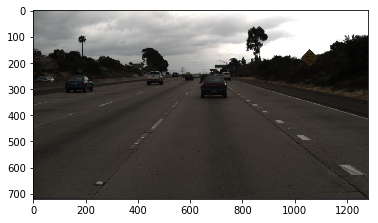

In [ ]:
# Python3
import cv2
import matplotlib.pyplot as plt
import numpy as np


img = cv2.cvtColor(cv2.imread("8.jpg"),cv2.COLOR_BGR2RGB) # convert from BGR to RGB
print(img.shape)
plt.figure()
plt.imshow(img)

In [ ]:

H , W , _ = img.shape
print(H, W)

(720, 1280)


In [ ]:
M1 = np.array([[0.954906       , 0.000000      ,  430],
[-0.024030      , 0.997664   ,     260],
[-0.000046    ,  0.0000100      ,  1]])
M = np.linalg.inv(M1)
# # calibration = M 
# img_transform = np.array([
#   [-1.0,  1.0, 430],
#   [ 1.0, -1.0, 2501],
#   [ 0.0,  0.0, 1.0]
# ])
# M = np.dot(img_transform, _BB_TO_FULL_FRAME)
print(M)

[[ 1.02602635e+00  4.43379852e-03 -4.42344117e+02]
 [ 1.24455693e-02  1.00501427e+00 -2.66655304e+02]
 [ 4.70727563e-05 -9.84618793e-06  9.82318724e-01]]


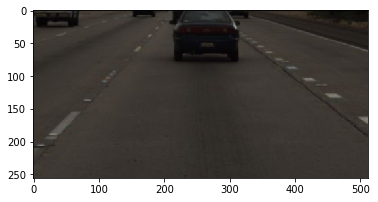

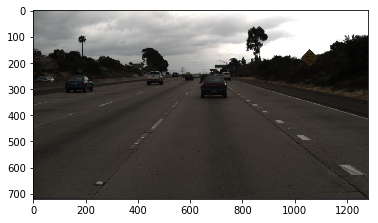

In [ ]:
out = cv2.warpPerspective(img,M,(512,256),flags=cv2.INTER_LINEAR)
out1 = cv2.resize(out,(320,160))
# out2 = cv2.warpPerspective(img,M4,(0, 0),flags=cv2.INTER_LINEAR)
# print(out.shape)
plt.figure()
plt.imshow(out)
plt.show()
plt.figure()
plt.imshow(img)
# plt.figure()
# plt.imshow(out1)

In [ ]:
height = 256 #846
width = 512 #1152

# dim = (width, height)
# res_img = cv2.resize(out, dim, interpolation = cv2.INTER_NEAREST) 
# print(res_img.shape)

img_yuv = cv2.cvtColor(out, cv2.COLOR_BGR2YUV_I420)
print(img_yuv.shape)

y_ul = []
y_ur = []
y_dl = []
y_dr = []

width = 256 #846
height = 512 #1152

(384, 512)


In [ ]:
for i in range(width): 
    for j in range(height): 
      if (i % 2 == 0 and j%2 == 0):
        y_ul.append(img_yuv[i , j]) 
      elif (i % 2 != 0 and j%2 == 0): 
        y_ur.append(img_yuv[i , j]) 
      elif (i % 2 == 0 and j%2 != 0):
        y_dl.append(img_yuv[i , j]) 
      else:
        y_dr.append(img_yuv[i , j])

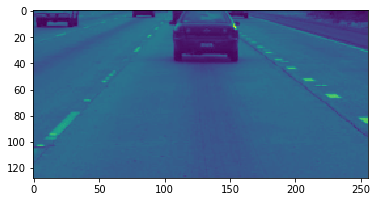

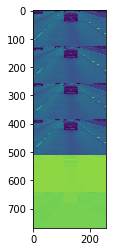

(6, 128, 256)
(196608,)


In [ ]:
y_ul = np.reshape(y_ul, (128, 256))
y_ur = np.reshape(y_ur, (128, 256))
y_dl = np.reshape(y_dl, (128, 256))
y_dr = np.reshape(y_dr, (128, 256))
img_yuv_flat = img_yuv.flatten()
U = img_yuv_flat[131072 : 163840]
V = img_yuv_flat[163840::]
U = np.reshape(U, (128, 256))
V = np.reshape(V, (128, 256))
plt.figure()
plt.imshow(y_dl)
plt.show()
merge = np.vstack([[y_ul],[y_dl],[y_ur],[y_dr], [U], [V]])
mshow = merge.reshape((128*6, 256))
plt.figure()
plt.imshow(mshow)
plt.show()
# merge1 = np.vstack([merge,merge])
merge1 = np.vstack([merge,merge]) # cv2 merge is wrong (was on monitoring)
print(np.shape(merge))
print(np.shape(img_yuv_flat))
merge2 = np.reshape(merge1,(1,12,128,256))
# print(np.shape(out2))

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
MODEL_PATH_DISTANCE =192
POLYFIT_DEGREE= 4
SPEED_PERCENTILES =10
DESIRE_LEN =8
DESIRE_PRED_SIZE =32
OTHER_META_SIZE= 4
LEAD_MDN_N =5 # probs for 5 groups
MDN_VALS= 4 # output xyva for each lead group
SELECTION =3 #output 3 group (lead now, in 2s and 6s)
MDN_GROUP_SIZE= 11
TIME_DISTANCE =100
POSE_SIZE= 12

In [ ]:
PATH_IDX =0
LL_IDX = PATH_IDX + MODEL_PATH_DISTANCE*2 + 1
RL_IDX = LL_IDX + MODEL_PATH_DISTANCE*2 + 2
LEAD_IDX= RL_IDX + MODEL_PATH_DISTANCE*2 + 2
LONG_X_IDX =LEAD_IDX + MDN_GROUP_SIZE*LEAD_MDN_N + SELECTION
LONG_V_IDX =LONG_X_IDX + TIME_DISTANCE*2
LONG_A_IDX =LONG_V_IDX + TIME_DISTANCE*2
DESIRE_STATE_IDX =LONG_A_IDX + TIME_DISTANCE*2
META_IDX = DESIRE_STATE_IDX + DESIRE_LEN
POSE_IDX = META_IDX + OTHER_META_SIZE + DESIRE_PRED_SIZE
OUTPUT_SIZE = POSE_IDX + POSE_SIZE

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras
from keras.models import load_model
from keras.models import Model
from keras.models import load_model
from keras import __version__ as keras_version
desire = np.zeros((1, 8))
rnn = np.zeros((1, 512))
model = tf.keras.models.load_model("/content/drive/My Drive/supercombo (3).keras")
path = []
left_lane = []
right_lane = []
lead = []
long_x = []
long_v = []
long_a = []
meta = []
snpe_pleaser2 = []
pose = []
add_3 = []

# path,left_lane,right_lane,lead,long_x,long_v,long_a,meta,snpe_pleaser2,pose,add_3,X
data = model.predict([merge2,desire,rnn])
# data lengths :
# [385, 386, 386, 58, 200, 200, 200, 8, 4, 32, 12, 512]
path = data[0][0] #data[PATH_IDX:LL_IDX]
left_lane = data[1][0] # data[LL_IDX:RL_IDX]
right_lane = data[2][0] # data[RL_IDX:LEAD_IDX]
lead = data[3][0] # data[LEAD_IDX:LONG_X_IDX]
# long_x = data[4][0] # data[LONG_X_IDX:LONG_V_IDX]
# long_v = data[5][0] # data[LONG_V_IDX:LONG_A_IDX]
# long_a = data[6][0] # data[LONG_A_IDX:DESIRE_STATE_IDX]
# meta = data[DESIRE_STATE_IDX:POSE_IDX]
# pose = data[POSE_IDX:]


# predictions = model.predict(merge2, batch_size=128)
# print("predictions", pred1, pred2, pred3,pred4, pred5, pred6,pred7)
print(path.shape,left_lane.shape,right_lane.shape)

Using TensorFlow backend.
W0614 11:57:43.161384 139892587915136 deprecation.py:506] From /tensorflow-1.15.2/python2.7/tensorflow_core/python/ops/init_ops.py:97: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0614 11:57:43.164060 139892587915136 deprecation.py:506] From /tensorflow-1.15.2/python2.7/tensorflow_core/python/ops/init_ops.py:97: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0614 11:57:43.177385 139892587915136 deprecation.py:506] From /tensorflow-1.15.2/python2.7/tensorflow_core/python/ops/init_ops.py:97: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be

((385,), (386,), (386,))


In [ ]:
# path = path[0,0:192]
# left_lane = left_lane[0,0:192]
# right_lane = right_lane[0,0:192]


In [ ]:
def poly_fit(in_pts, in_stds, out):
  # References to inputs
  # Eigen::Map<Eigen::Matrix<float, MODEL_PATH_DISTANCE, 1> > pts(in_pts, MODEL_PATH_DISTANCE);
  # Eigen::Map<Eigen::Matrix<float, MODEL_PATH_DISTANCE, 1> > std(in_stds, MODEL_PATH_DISTANCE);
  # Eigen::Map<Eigen::Matrix<float, POLYFIT_DEGREE - 1, 1> > p(out, POLYFIT_DEGREE - 1)
  # Eigen::Matrix<float, MODEL_PATH_DISTANCE, POLYFIT_DEGREE - 1> vander;

  vander = []
  lhs = []
  var_colwise = []
  scale1 = []

  for i in range(MODEL_PATH_DISTANCE):
    row = []
    for j in range(POLYFIT_DEGREE - 1):
      row.append(0)
    vander.append(row)
    lhs.append(row)
    scale1.append(row)

  for i in range(0,MODEL_PATH_DISTANCE) :
    for j in range(0,POLYFIT_DEGREE-1) :
      vander[i][j] = pow(i, POLYFIT_DEGREE-j-1)  

  for j in range(0,POLYFIT_DEGREE-1) :  
    for i in range(0,MODEL_PATH_DISTANCE) :
      var_colwise.append(vander[i][j])

  y0 = in_pts[0]
  in_pts = np.array(in_pts)- y0
  

  
  
  # Build Least Squares equations
  # Eigen::Matrix<float, MODEL_PATH_DISTANCE, POLYFIT_DEGREE - 1> lhs = vander.array().colwise() / std.array();
  for i in range(0,POLYFIT_DEGREE-1):
    lhs[:][i] = np.array(var_colwise[i])/np.array(in_stds)

  # Eigen::Matrix<float, MODEL_PATH_DISTANCE, 1> rhs = pts.array() / std.array();
  rhs = np.array(in_pts)/np.array(in_stds)
  print(rhs.shape)
  import math
  # # Improve numerical stability
  # Eigen::Matrix<float, POLYFIT_DEGREE - 1, 1> scale = 1. / (lhs.array()*lhs.array()).sqrt().colwise().sum();
  scale = []
  for i in range(0,POLYFIT_DEGREE-1):
    for j in range(0,MODEL_PATH_DISTANCE):
      scale1[j][i]=(math.sqrt(lhs[j][i]*lhs[j][i]))
    scale.append(sum(scale1[:][i]))


  # lhs = lhs * scale.asDiagonal();
  lhs = np.array(lhs)
  lhs = lhs.dot(np.array(np.diag(scale)))
  # Solve inplace
  # Eigen::ColPivHouseholderQR<Eigen::Ref<Eigen::MatrixXf> > qr(lhs)
  # p = qr.solve(rhs)
  p = np.linalg.lstsq(np.array(lhs),np.array(rhs))
  print(p)
  p = np.array(p[:3])
  # # Apply scale to output
  p = p*(np.diag(scale))
  out[3] = y0



In [ ]:
def sigmoid(input):
  return 1 / (1 + np.exp(-input))

def softplus(input):
  return np.log1p(np.exp(input))

def model_polyfit(points, path_pinv):
  return np.dot(path_pinv, [x for x in points])  


In [ ]:
def fill_path(data,has_prob,offset):

  points_arr = []
  stds_arr = []
  poly_arr = []

  valid_len =  data[MODEL_PATH_DISTANCE*2]
  for i in range(0,MODEL_PATH_DISTANCE):
    points_arr.append(data[i] + offset)
    if i < 5 and i < valid_len:
      stds_arr.append(softplus(data[MODEL_PATH_DISTANCE + i]))
    else:
      stds_arr.append(1.0e3)

  if has_prob:
    prob =  sigmoid(data[MODEL_PATH_DISTANCE*2 + 1])
  else :
    prob = 1.0
  for i in range(0,POLYFIT_DEGREE):
    poly_arr.append([])

  std = softplus(data[MODEL_PATH_DISTANCE])
  print('std',std)
  print('std_arr',stds_arr)
  print('prob',prob)
  print('points:',points_arr)

  poly_fit(points_arr, stds_arr, poly_arr)

#   if (std::getenv("DEBUG")){
#     kj::ArrayPtr<const float> stds(&stds_arr[0], ARRAYSIZE(stds_arr));
#     path.setStds(stds);

#     kj::ArrayPtr<const float> points(&points_arr[0], ARRAYSIZE(points_arr));
#     path.setPoints(points);
#   }

  poly = np.array(model_polyfit(points_arr, _PATH_PINV.T))

  # print('poly:',poly)
  return poly,std,prob

#   kj::ArrayPtr<const float> poly(&poly_arr[0], ARRAYSIZE(poly_arr));
#   path.setPoly(poly);
#   path.setProb(prob);
#   path.setStd(std);


In [ ]:
poly,std,prob = fill_path(path, False, 0)
poly,std,prob = fill_path(left_lane, True, 1.8)
poly,std,prob =  fill_path(right_lane, True, -1.8)

('std', 0.6005085)
('std_arr', [0.6005085, 0.5407648, 0.598437, 0.61943984, 0.53803486, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [ ]:
class ModelPoly(object):
  def __init__(self, model_path, offset, has_prob):
    # if len(model_path) == 0 and len(model_path.poly) == 0:
    #   self.valid = False
    #   return
    self.offset = offset

    self.points = []
    for i in range(0,MODEL_PATH_DISTANCE):
      self.points.append(model_path[i] + self.offset)


    # self.poly = np.polyfit(self.points, self.stds_arr, POLYFIT_DEGREE)
    self.poly = np.array(model_polyfit(self.points, _PATH_PINV.T))
    # self.poly = np.polyfit(model_path, _PATH_PINV, 0)
    print('poly:' )
    print(self.poly.shape)
    
    # mean = np.mean(model_path)
    # self.std = np.std(model_path)
    self.std = softplus(model_path[MODEL_PATH_DISTANCE])
    if has_prob:
      self.prob = sigmoid(model_path[MODEL_PATH_DISTANCE*2 +1])
    else:
      self.prob = 1.0
    # self.prob = (np.random.normal(mean,self.std))
    print('prob:' )
    print(self.prob)

    # print('std:' )
    # print(self.std)

    self.y = np.polyval(self.poly, _PATH_XD)
    # print('y:' )
    # print(self.y.shape)
    self.valid = True

    

In [ ]:
def extract_model_data():
  return ModelUIData(
    cpath=ModelPoly(path,0, False),
    lpath=ModelPoly(left_lane,1.8, True),
    rpath=ModelPoly(right_lane,-1.8, True),
    lead= lead)
# def extract_model_data():
#   return ModelUIData(cpath=path,lpath=left_lane,rpath=right_lane,lead=lead) 

In [ ]:
# MEDMODEL
eon_focal_length = FOCAL = 720 #1.533e+03 720
MEDMODEL_INPUT_SIZE = (521,256)
MEDMODEL_YUV_SIZE = (MEDMODEL_INPUT_SIZE[0], MEDMODEL_INPUT_SIZE[1] * 3 // 2)
MEDMODEL_CY = 47

medmodel_zoom = 1
model_height = 1.22

medmodel_intrinsics =np.array(
  [[ eon_focal_length / medmodel_zoom,    0. ,   0.5* MEDMODEL_INPUT_SIZE[0]],
   [   0. ,  eon_focal_length / medmodel_zoom,  MEDMODEL_CY],
   [   0. ,                            0. ,   1.]])



view_from_road = np.array([[0, -1, 0],
                           [0, 0, -1],
                           [1, 0, 0]])
medmodel_frame_from_road_frame = np.dot(medmodel_intrinsics,
  np.hstack((view_from_road, [[0], [model_height], [0]])))



ground_from_medmodel_frame = np.linalg.inv(medmodel_frame_from_road_frame[:,(0,1,3)])

('calibration:', array([[ 6.78753013e+02, -6.87532320e+02,  0.00000000e+00],
       [ 3.00630393e+02,  1.73016000e+01,  8.76348058e+02],
       [ 9.88487000e-01,  3.31200000e-02,  8.78400000e-03]]))
poly:
(5,)
prob:
1.0
poly:
(5,)
prob:
0.07148637872435958
poly:
(5,)
prob:
0.019743435656353777


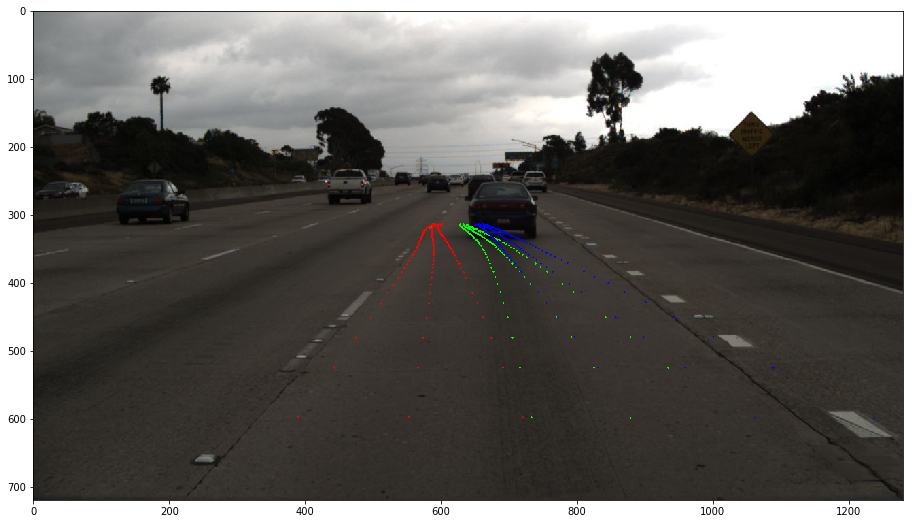

In [ ]:
M1 = np.array([[0.954906       , 0.000000      ,  430],
[-0.024030      , 0.997664   ,     260],
[-0.000046    ,  0.0000100      ,  1]])
calibration = np.dot(M1,np.linalg.inv(ground_from_medmodel_frame))#np.linalg.inv(ground_from_medmodel_frame)_
print("calibration:",  calibration)
model_data = extract_model_data()
# print(model_data.lpath.poly)
# print(model_data.cpath)
# print(model_data.rpath)

out2 = out.copy()
img2 = img.copy()
plot_model(model_data,img2,calibration)

In [ ]:
M_PI = 3.14159265358979323846

In [ ]:
def posenet_publish(pose):
  # capnp::MallocMessageBuilder msg;
  # cereal::Event::Builder event = msg.initRoot<cereal::Event>();
  # event.setLogMonoTime(nanos_since_boot());

  trans_std_arr=[]
  trans_arr=[]
  rot_arr=[]
  rot_std_arr=[]

  for i in range(3):
    trans_arr.append(0)
    trans_std_arr.append(0)
    rot_arr.append(0)
    rot_std_arr.append(0)

  for i in range(3):
    trans_arr[i] = pose[i];
    trans_std_arr[i] = softplus(pose[6 + i]) + 1e-6

    rot_arr[i] = M_PI * pose[3 + i] / 180.0;
    rot_std_arr[i] = M_PI * (softplus(pose[9 + i]) + 1e-6) / 180.0


  print(trans_std_arr)  
  print(trans_arr)
  print(rot_arr)
  print(rot_std_arr)
  return trans_std_arr,trans_arr,rot_arr,rot_std_arr

In [ ]:
pose = data[9][0]
trans_std_arr,trans_arr,rot_arr,rot_std_arr = posenet_publish(pose)
print("pose:",pose)

[0.6931481824645996, 1.313259647918701, 0.6931481824645996]
[7.777315e-09, 1.066932e-10, 4.152784e-06]
[8.613789633486587e-11, 1.237050071007606e-13, 2.437369132428284e-14]
[0.012097717988221686, 0.012097717988221686, 0.012097717988221686]
('pose:', array([7.7773148e-09, 1.0669320e-10, 4.1527842e-06, 4.9353379e-09,
       7.0877748e-12, 1.3965096e-12, 0.0000000e+00, 9.9999583e-01,
       8.8649074e-11, 2.1387247e-12, 3.1153839e-08, 5.3354077e-09,
       1.7473674e-13, 7.7234605e-14, 0.0000000e+00, 1.0000000e+00,
       1.0071220e-12, 6.3388400e-13, 2.4174571e-07, 1.2846079e-08,
       1.4704690e-12, 1.1414750e-13, 0.0000000e+00, 9.9999976e-01,
       2.3777700e-13, 2.0902787e-12, 6.8246000e-06, 1.6026993e-07,
       2.6934188e-11, 1.3434139e-12, 0.0000000e+00, 9.9999309e-01],
      dtype=float32))
